# Hyper Parameter Optimization

## HPO 탐색 방법

In [1]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns

df = sns.load_dataset('titanic')
cols = ['age', 'sibsp', 'parch', 'fare']
features = df[cols]
target = df['survived']

- 데이터 인코딩

In [5]:
from sklearn.preprocessing import OneHotEncoder

cols = ['pclass', 'sex', 'embarked']

enc = OneHotEncoder(handle_unknown='ignore')
tmp = pd.DataFrame(
      enc.fit_transform(df[cols]).toarray(),
      columns = enc.get_feature_names_out()
)

features = pd.concat([features, tmp], axis=1)

- 결측치 제거

In [6]:
features.age = features.age.fillna(features.age.median())

- 데이터 스케일링

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

- 데이터 분리

In [9]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

random_state = 42

X_tr, X_te, y_tr, y_te = train_test_split(features, target, test_size=0.2, random_state=random_state, shuffle=True)

X_tr.shape, X_te.shape

((712, 13), (179, 13))

- 검증

In [10]:
n_iter = 50
# 일반적으로는 5개 
num_fold = 2

kf = KFold(n_splits=num_fold, shuffle=True, random_state=random_state)

In [34]:
def print_scores(y_te,pred):
  print(confusion_matrix(y_te,pred))
  print('-'*50)
  print(classification_report(y_te,pred))

### Manual Search
- 사람이 수동으로 파라미터를 변경하는 작업

In [35]:
from lightgbm.sklearn import LGBMClassifier

In [36]:
hp = {
    "max_depth": 5,
    "criterion" : "gini",
    "n_estimators" : 50,
    "learning_rate" : 0.1
}

model = LGBMClassifier(**hp, random_state=random_state).fit(X_tr,y_tr)

In [37]:
pred = model.predict(X_te)
print_scores(y_te, pred)

[[95 10]
 [21 53]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       105
           1       0.84      0.72      0.77        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.82       179



In [38]:
hp = {
    "max_depth": 4,
    "criterion" : "entropy",
    "n_estimators" : 150,
    "learning_rate" : 0.01
}

model = LGBMClassifier(**hp, random_state=random_state).fit(X_tr,y_tr)
pred = model.predict(X_te)
print_scores(y_te, pred)

[[93 12]
 [25 49]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.89      0.83       105
           1       0.80      0.66      0.73        74

    accuracy                           0.79       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179



### Grid Search 

In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
hp = {
    'max_depth' : np.linspace(5, 12, 8, dtype=int), # 깊이
    'criterion' : ['gini', 'entropy'], # 순수도 척도 
    'n_estimators' : np.linspace(800, 1200, 5, dtype=int), # 부스팅 단계수 
    'learning_rate' : np.logspace(-3, 1, 3) 
}

model = LGBMClassifier(random_state=random_state)

gs = GridSearchCV(model, hp, scoring='roc_auc', n_jobs=-1, cv=kf, verbose=False).fit(X_tr, y_tr)

In [42]:
gs.best_params_

{'criterion': 'gini',
 'learning_rate': 0.001,
 'max_depth': 6,
 'n_estimators': 900}

In [43]:
gs.best_score_

0.8361541598172667

In [45]:
gs.score(X_te, y_te)

0.874839124839125

In [46]:
pred = gs.predict_proba(X_te)[: , 1]
roc_auc_score(y_te, pred)

0.874839124839125

In [47]:
pred = gs.best_estimator_.predict(X_te)
print_scores(y_te, pred)

[[96  9]
 [28 46]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.91      0.84       105
           1       0.84      0.62      0.71        74

    accuracy                           0.79       179
   macro avg       0.81      0.77      0.78       179
weighted avg       0.80      0.79      0.79       179



<AxesSubplot:xlabel='param_criterion', ylabel='param_n_estimators'>

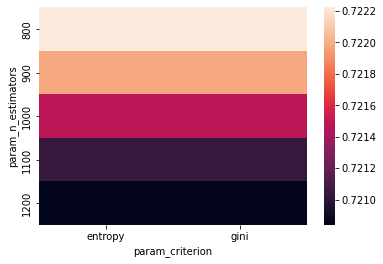

In [49]:
table = pd.pivot_table(pd.DataFrame(gs.cv_results_),
                       values='mean_test_score',  index='param_n_estimators', 
                       columns = 'param_criterion')

sns.heatmap(table)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

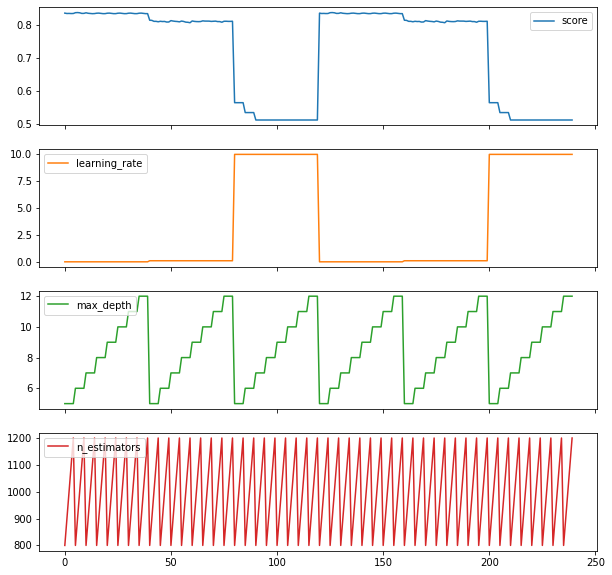

In [51]:
# 각 파라미터별로 score와의 상관관계 파악 후 없다면 제거해야 한다. 

gs_results_df = pd.DataFrame(np.transpose([gs.cv_results_['mean_test_score'],
                                                                                  gs. cv_results_['param_learning_rate'].data,
                                                                                  gs.cv_results_['param_max_depth'].data,
                                                                                  gs.cv_results_['param_n_estimators'].data]),
                                                              columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
gs_results_df.plot(subplots=True, figsize=(10, 10))

- learning rate가 다른 파라미터보다 영향이 크다는 것을 알 수 있다. 

### Random Search
- 탐색 구간 안에서 임의로 파라미터 선택
- 그리드 서치의 문제점을 보안하기 위해 고안된 기법
- 구간 내 랜덤 조합을 사용하기 때문에 더 많은 지점을 살펴보고 있고, 불필요한 반복 탐색이 줄어들어 속도가 빠르다.

In [52]:
from sklearn.model_selection import RandomizedSearchCV

In [67]:
hp = {
    'max_depth' : np.linspace(5, 12, 8, dtype=int),
    'criterion' : ['gini', 'entropy'],
    'n_estimators' : np.linspace(800, 1200, 5, dtype=int),
    'learning_rate' : np.logspace(-3, -1, 3)
}

model = LGBMClassifier(random_state=random_state)

rs=RandomizedSearchCV(model, hp, scoring='roc_auc', n_iter=n_iter, n_jobs=-1, cv=kf, verbose=False).fit(X_tr,y_tr)
rs.best_score_, rs.score(X_te,y_te)

(0.8357934740877058, 0.8736164736164735)

In [68]:
pred = rs.predict_proba(X_te)[:,1]
roc_auc_score(y_te,pred)

0.8736164736164735

In [71]:
pred = rs.best_estimator_.predict(X_te)
print_scores(y_te, pred)

[[97  8]
 [29 45]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       105
           1       0.85      0.61      0.71        74

    accuracy                           0.79       179
   macro avg       0.81      0.77      0.77       179
weighted avg       0.80      0.79      0.79       179



<AxesSubplot:xlabel='param_criterion', ylabel='param_n_estimators'>

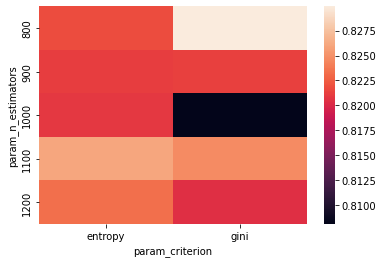

In [72]:
table = pd.pivot_table(pd.DataFrame(rs.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
                       columns='param_criterion')
     
sns.heatmap(table)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

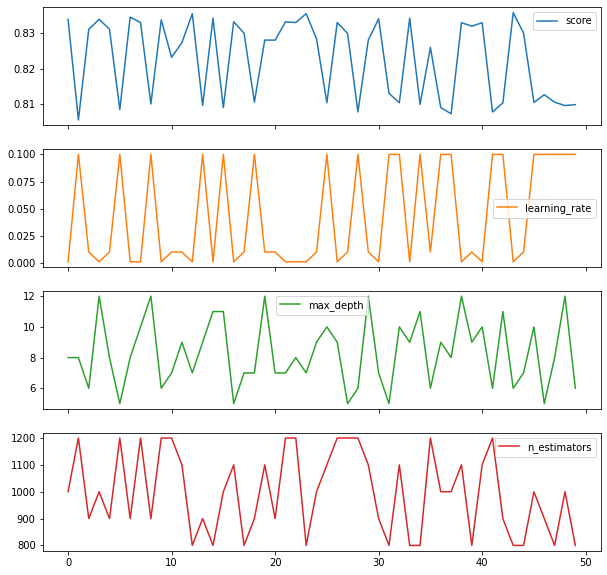

In [70]:
rs_results_df=pd.DataFrame(np.transpose([rs.cv_results_['mean_test_score'],
                                         rs.cv_results_['param_learning_rate'].data,
                                         rs.cv_results_['param_max_depth'].data,
                                         rs.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

Text(0, 0.5, 'best_cumulative_score')

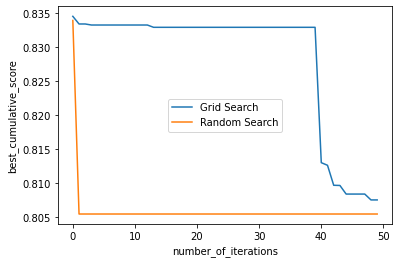

In [75]:
scores_df=pd.DataFrame(index=range(n_iter))
scores_df['Grid Search']=gs_results_df['score'].cummin()
scores_df['Random Search']=rs_results_df['score'].cummin()

ax = scores_df.plot()
ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")

### Bayesian Search

- 단순 점을 찍어 선택하는 것이 아니라 추가학습을 해서 전체 그래프를 추정

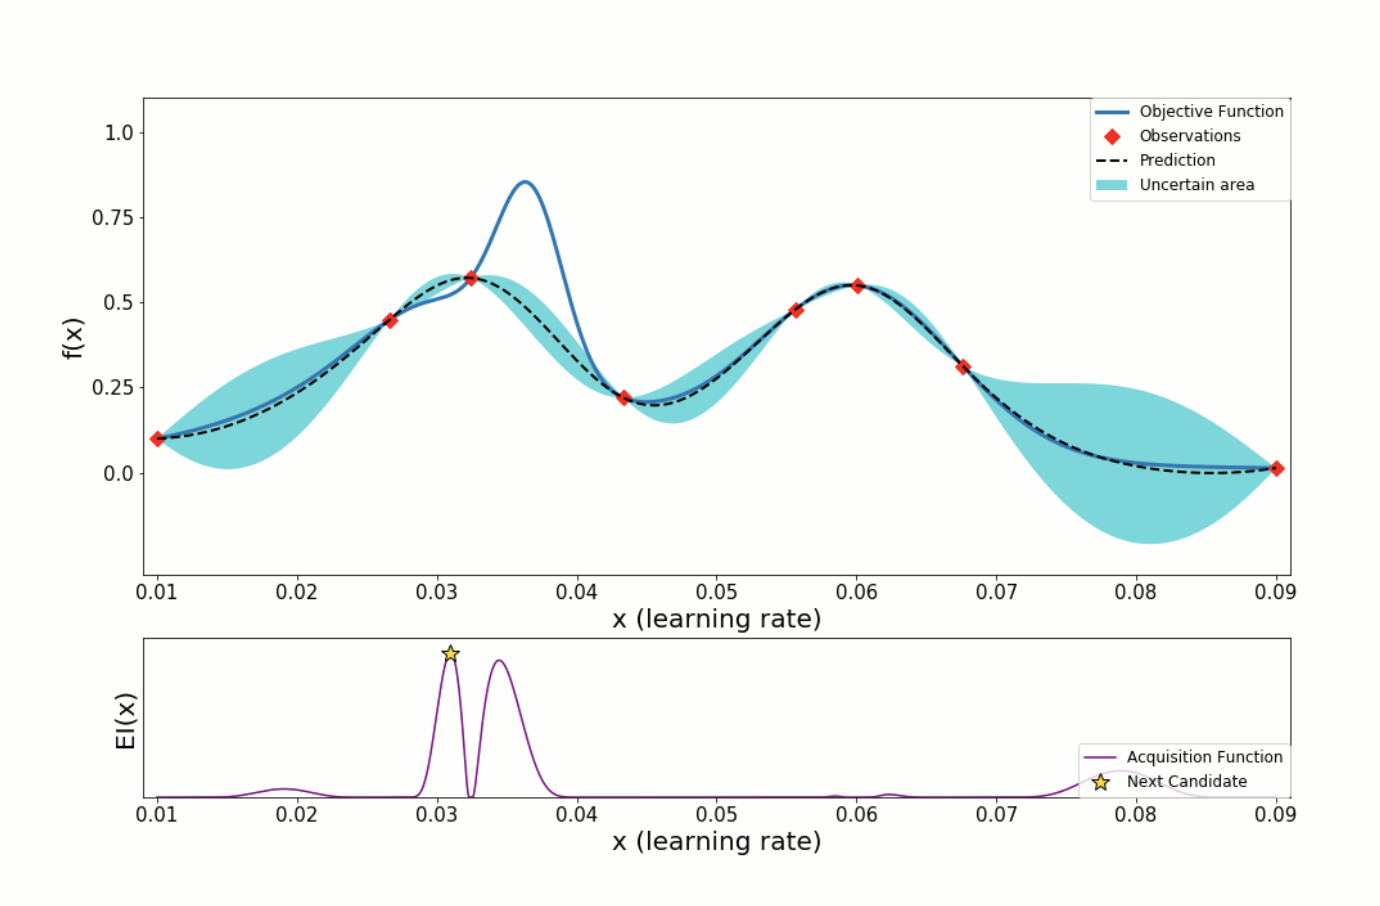

#### optuna 라이브러리

In [76]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.8 MB/s eta 0:00:00


In [77]:
import optuna
from sklearn.model_selection import cross_val_score

#### TPE Sampler

In [78]:
from optuna.samplers import TPESampler
optuna.logging.disable_default_handler()

목적 함수

In [88]:
class Objective :
  def __init__(self, x_train, y_train, seed) :
    self.x_train = x_train
    self.y_train = y_train
    self.seed = seed
  
    num_folds =2 
    self.cv = KFold(n_splits=num_folds, shuffle=True, random_state=self.seed)
  
  def __call__(self, trial) :
        hp = {
            "max_depth" : trial.suggest_int("max_depth",2,5),
            "min_samples_split" : trial.suggest_int("min_samples_split",2,5),
            "criterion" : trial.suggest_categorical("criterion",["gini","entropy"]),
            "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes",5,10),
            "n_estimators" : trial.suggest_int("n_estimators",10,500,50),
            "learning_rate" : trial.suggest_float("learning_rate",0.01,0.1)
        }
        model = LGBMClassifier(random_state=self.seed,**hp)
        scores = cross_val_score(model,self.x_train,self.y_train, cv = self.cv , scoring="roc_auc")
        return np.mean(scores)

학습

In [89]:
sampler = TPESampler(seed=random_state)

study = optuna.create_study(
    direction = 'maximize',
    sampler = sampler
)

objective = Objective(X_tr, y_tr, random_state)
study.optimize(objective,n_trials=50)

print("Best Score", study.best_value) # 최고 점수
print('Best hp', study.best_params) # 최고 점수의 하이퍼 파라미터 조합 

Best Score 0.8544399928115755
Best hp {'max_depth': 2, 'min_samples_split': 4, 'criterion': 'entropy', 'max_leaf_nodes': 6, 'n_estimators': 110, 'learning_rate': 0.058907446212311886}


In [90]:
model = LGBMClassifier(random_state=random_state, **study.best_params)
model.fit(X_tr,y_tr)

pred = model.predict_proba(X_te)[:,1]
roc_auc_score(y_te,pred)

0.8902831402831403

In [91]:
optuna.visualization.plot_param_importances(study)

In [92]:
optuna.visualization.plot_optimization_history(study)